# Experiment 4.2.3: Gaussian Process Regression (3D)

This notebook evaluates the effectiveness of different point sets for Gaussian Process Regression (GPR) in 3D.

Uses optimal Korobov parameters from Table korobov_optimal_a.

**Test Functions (Genz Family):**
1. **Genz Continuous** - Smooth function with exponential decay
2. **Genz Gaussian** - Localized Gaussian peak

**Comparison:** Korobov, Explicit rank-1, Random, Halton, Sobol point sets

## Setup

In [11]:
# Uncomment for Google Colab
# !pip install numpy scipy matplotlib qmcpy scikit-learn

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn for GPR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C

# Import from lattice_qmc package
from lattice_qmc import KorobovLattice, ExplicitRank1Lattice

# QMCPy for Halton and Sobol
try:
    import qmcpy as qp
    QMCPY_AVAILABLE = True
    print("QMCPy loaded successfully.")
except ImportError:
    QMCPY_AVAILABLE = False
    print("QMCPy not available.")

# Publication-quality plot settings
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 10,
    'figure.figsize': (10, 7),
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

np.random.seed(42)
print("Setup complete!")

QMCPy loaded successfully.
Setup complete!


## Helper Functions

In [13]:
def generate_halton_points(n: int, d: int) -> np.ndarray:
    if not QMCPY_AVAILABLE:
        raise ImportError("QMCPy required.")
    halton = qp.Halton(d, seed=42)
    return halton.gen_samples(n)

def generate_sobol_points(n: int, d: int) -> np.ndarray:
    if not QMCPY_AVAILABLE:
        raise ImportError("QMCPy required.")
    sobol = qp.Sobol(d, seed=42)
    return sobol.gen_samples(n)

print("Point set generators loaded.")

Point set generators loaded.


## Load Optimal Korobov Parameters

In [14]:
# Load optimal Korobov parameters from experiment 4.1.1
try:
    korobov_params = np.load('data/korobov_optimal_parameters.npy', allow_pickle=True).item()
    korobov_primes = korobov_params['primes']
    optimal_generators = korobov_params['optimal_generators']
    print("Loaded optimal Korobov parameters from file.")
    print(f"Available dimensions: {list(optimal_generators.keys())}")
    # Use the same Korobov primes and generators as in 04_01_03
    korobov_primes_3d = korobov_primes[2:9]
    korobov_generators_3d = optimal_generators[3][2:9] if optimal_generators is not None else None
    print(f"\nSelected primes for 3D: {korobov_primes_3d}")
    print(f"Optimal generators a* for d=3: {korobov_generators_3d}")
except FileNotFoundError:
    print("Warning: Could not load optimal parameters. Using default primes.")
    korobov_primes_3d = [13, 31, 61, 127, 251, 509, 1021]
    korobov_generators_3d = None
    optimal_generators = None

Loaded optimal Korobov parameters from file.
Available dimensions: [2, 3, 5, 7]

Selected primes for 3D: [  13   31   61  127  251  509 1021]
Optimal generators a* for d=3: [2, 17, 15, 102, 106, 225, 516]


---

## Part 1: 3D Test Functions (Genz Family)

The **Genz test functions** are standard benchmarks for numerical integration and surrogate modeling.

### 1.1 Genz Continuous Function

$$
f(x) = \exp\left( -\sum_{i=1}^{d} c_i |x_i - u_i| \right)
$$

A smooth function with a peak at $u$. The parameter $c$ controls the sharpness.

In [15]:
def genz_continuous(X: np.ndarray, c: np.ndarray = None, u: np.ndarray = None) -> np.ndarray:
    """
    Genz Continuous test function.
    
    f(x) = exp(-sum(c_i * |x_i - u_i|))
    
    Parameters
    ----------
    X : np.ndarray
        Points of shape (n, d) in [0, 1]^d.
    c : np.ndarray, optional
        Sharpness parameters.
    u : np.ndarray, optional
        Peak location.
    
    Returns
    -------
    np.ndarray
        Function values of shape (n,).
    """
    d = X.shape[1]
    if c is None:
        c = np.array([1.5, 2.0, 2.5])[:d]  # Moderate difficulty
    if u is None:
        u = 0.5 * np.ones(d)
    
    return np.exp(-np.sum(c * np.abs(X - u), axis=1))


# Test
d = 3
test_pts = np.array([[0.5]*d, [0.0]*d, [1.0]*d])
print("Genz Continuous function values:")
print(genz_continuous(test_pts))

Genz Continuous function values:
[1.         0.04978707 0.04978707]


### 1.2 Genz Gaussian (Product Peak)

$$
f(x) = \exp\left( -\sum_{i=1}^{d} c_i^2 (x_i - u_i)^2 \right)
$$

A Gaussian-like function centered at $u$. More challenging due to localized feature.

In [16]:
def genz_gaussian(X: np.ndarray, c: np.ndarray = None, u: np.ndarray = None) -> np.ndarray:
    """
    Genz Gaussian test function.
    
    f(x) = exp(-sum(c_i^2 * (x_i - u_i)^2))
    
    Parameters
    ----------
    X : np.ndarray
        Points of shape (n, d) in [0, 1]^d.
    c : np.ndarray, optional
        Width parameters (larger = narrower peak).
    u : np.ndarray, optional
        Peak location.
    
    Returns
    -------
    np.ndarray
        Function values of shape (n,).
    """
    d = X.shape[1]
    if c is None:
        c = np.array([3.0, 3.0, 3.0])[:d]  # Moderately localized
    if u is None:
        u = 0.5 * np.ones(d)
    
    return np.exp(-np.sum(c**2 * (X - u)**2, axis=1))


print("Genz Gaussian function values:")
print(genz_gaussian(test_pts))

Genz Gaussian function values:
[1.         0.00117088 0.00117088]


---

## Part 2: GPR Implementation

In [17]:
def fit_gpr(X_train: np.ndarray, y_train: np.ndarray, alpha: float = 1e-6) -> GaussianProcessRegressor:
    """
    Fit a Gaussian Process Regressor.
    """
    kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=0.3, 
                                           length_scale_bounds=(1e-2, 1e1),
                                           nu=2.5)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha, 
                                   n_restarts_optimizer=3,
                                   normalize_y=True)
    gpr.fit(X_train, y_train)
    return gpr


def compute_l2_error_mc(gpr: GaussianProcessRegressor, 
                        true_func: Callable,
                        d: int,
                        n_mc: int = 10000,
                        seed: int = 12345) -> float:
    """
    Compute L² error using Monte Carlo integration.
    """
    np.random.seed(seed)
    X_mc = np.random.rand(n_mc, d)
    
    f_true = true_func(X_mc)
    f_gpr = gpr.predict(X_mc)
    
    l2_error_sq = np.mean((f_true - f_gpr)**2)
    return np.sqrt(l2_error_sq)


# Configuration
NOISE_STD = 0.05
N_TRIALS = 100

print("GPR functions loaded.")
print(f"Noise std: {NOISE_STD}, Number of trials: {N_TRIALS}")

GPR functions loaded.
Noise std: 0.05, Number of trials: 100


---

## Part 3: Run Experiments

### 3.1 Configuration

In [18]:
d = 3

# Point counts for each method (use optimal parameters from data file)
# korobov_primes_3d and korobov_generators_3d are loaded above
explicit_m_by_d = {2: 7, 3: 12, 5: 10, 7: 5}  # from 04_01_03
explicit_m_3d = explicit_m_by_d[3]
explicit_m_values = list(range(6, explicit_m_3d + 1))
powers = [16, 32, 64, 128, 256, 512, 1024]

print(f"Configuration for d = {d}:")
print(f"  Korobov primes (with optimal a*): {korobov_primes_3d}")
print(f"  Explicit m values: {explicit_m_values}")
print(f"  Powers for random/halton/sobol: {powers}")

Configuration for d = 3:
  Korobov primes (with optimal a*): [  13   31   61  127  251  509 1021]
  Explicit m values: [6, 7, 8, 9, 10, 11, 12]
  Powers for random/halton/sobol: [16, 32, 64, 128, 256, 512, 1024]


### 3.2 Run Experiment Function

In [19]:
def run_gpr_experiment(test_func: Callable, func_name: str, d: int, n_trials: int = N_TRIALS):
    """
    Run GPR experiment for all point set types with noisy observations.
    Uses optimal Korobov generators when available.
    """
    results = {
        'korobov': {'N': [], 'l2_error_mean': [], 'l2_error_std': []},
        'explicit': {'N': [], 'l2_error_mean': [], 'l2_error_std': [], 'm': []},
        'random': {'N': [], 'l2_error_mean': [], 'l2_error_std': []},
        'halton': {'N': [], 'l2_error_mean': [], 'l2_error_std': []},
        'sobol': {'N': [], 'l2_error_mean': [], 'l2_error_std': []},
    }
    
    print(f"\n{'='*60}")
    print(f"GPR Experiment: {func_name} (d = {d})")
    print(f"Noise std: {NOISE_STD}, Trials: {n_trials}")
    print(f"{'='*60}")
    
    # Korobov lattices - use optimal generators
    print("\nKorobov lattices (using optimal generators from Table korobov_optimal_a):")
    for idx, N in enumerate(korobov_primes_3d):
        print(f"  N = {N}", end="")
        if korobov_generators_3d is not None:
            a_star = korobov_generators_3d[idx]
            print(f" (a*={a_star}): ", end="", flush=True)
            lattice = KorobovLattice(d=d, N=N, generator=a_star, verbose=False)
        else:
            print(": ", end="", flush=True)
            lattice = KorobovLattice(d=d, N=N, criterion="product", verbose=False)
        
        X_train = lattice.points
        y_true = test_func(X_train)
        
        errors = []
        for trial in range(n_trials):
            np.random.seed(1000 + trial)
            y_noisy = y_true + np.random.normal(0, NOISE_STD, size=y_true.shape)
            gpr = fit_gpr(X_train, y_noisy)
            l2_error = compute_l2_error_mc(gpr, test_func, d=d)
            errors.append(l2_error)
        
        results['korobov']['N'].append(N)
        results['korobov']['l2_error_mean'].append(np.mean(errors))
        results['korobov']['l2_error_std'].append(np.std(errors))
        print(f"L² = {np.mean(errors):.6e} ± {np.std(errors):.6e}")
    
    # Explicit rank-1 lattices
    print("\nExplicit rank-1 lattices (p=2):")
    p = 2
    alpha = np.array([p**(j/(d+1)) for j in range(1, d+1)])
    for m in explicit_m_values:
        print(f"  m = {m}: ", end="", flush=True)
        lattice = ExplicitRank1Lattice(d=d, m=m, alpha=alpha, verbose=False)
        X_train = lattice.points
        y_true = test_func(X_train)
        
        errors = []
        for trial in range(n_trials):
            np.random.seed(1000 + trial)
            y_noisy = y_true + np.random.normal(0, NOISE_STD, size=y_true.shape)
            gpr = fit_gpr(X_train, y_noisy)
            l2_error = compute_l2_error_mc(gpr, test_func, d=d)
            errors.append(l2_error)
        
        results['explicit']['N'].append(lattice.Q)
        results['explicit']['l2_error_mean'].append(np.mean(errors))
        results['explicit']['l2_error_std'].append(np.std(errors))
        results['explicit']['m'].append(m)
        print(f"Q = {lattice.Q}, L² = {np.mean(errors):.6e} ± {np.std(errors):.6e}")
    
    # Random points
    print("\nRandom points:")
    for n in powers:
        print(f"  N = {n}: ", end="", flush=True)
        errors = []
        for trial in range(n_trials):
            np.random.seed(42 + trial)
            X_train = np.random.rand(n, d)
            y_true = test_func(X_train)
            np.random.seed(1000 + trial)
            y_noisy = y_true + np.random.normal(0, NOISE_STD, size=y_true.shape)
            gpr = fit_gpr(X_train, y_noisy)
            l2_error = compute_l2_error_mc(gpr, test_func, d=d)
            errors.append(l2_error)
        
        results['random']['N'].append(n)
        results['random']['l2_error_mean'].append(np.mean(errors))
        results['random']['l2_error_std'].append(np.std(errors))
        print(f"L² = {np.mean(errors):.6e} ± {np.std(errors):.6e}")
    
    # Halton
    if QMCPY_AVAILABLE:
        print("\nHalton sequence:")
        for n in powers:
            print(f"  N = {n}: ", end="", flush=True)
            X_train = generate_halton_points(n, d)
            y_true = test_func(X_train)
            
            errors = []
            for trial in range(n_trials):
                np.random.seed(1000 + trial)
                y_noisy = y_true + np.random.normal(0, NOISE_STD, size=y_true.shape)
                gpr = fit_gpr(X_train, y_noisy)
                l2_error = compute_l2_error_mc(gpr, test_func, d=d)
                errors.append(l2_error)
            
            results['halton']['N'].append(n)
            results['halton']['l2_error_mean'].append(np.mean(errors))
            results['halton']['l2_error_std'].append(np.std(errors))
            print(f"L² = {np.mean(errors):.6e} ± {np.std(errors):.6e}")
        
        # Sobol
        print("\nSobol sequence:")
        for n in powers:
            print(f"  N = {n}: ", end="", flush=True)
            X_train = generate_sobol_points(n, d)
            y_true = test_func(X_train)
            
            errors = []
            for trial in range(n_trials):
                np.random.seed(1000 + trial)
                y_noisy = y_true + np.random.normal(0, NOISE_STD, size=y_true.shape)
                gpr = fit_gpr(X_train, y_noisy)
                l2_error = compute_l2_error_mc(gpr, test_func, d=d)
                errors.append(l2_error)
            
            results['sobol']['N'].append(n)
            results['sobol']['l2_error_mean'].append(np.mean(errors))
            results['sobol']['l2_error_std'].append(np.std(errors))
            print(f"L² = {np.mean(errors):.6e} ± {np.std(errors):.6e}")
    
    return results

### 3.3 Run Experiments

In [20]:
# Experiment 1: Genz Continuous
results_continuous = run_gpr_experiment(genz_continuous, "Genz Continuous", d=3)


GPR Experiment: Genz Continuous (d = 3)
Noise std: 0.05, Trials: 100

Korobov lattices (using optimal generators from Table korobov_optimal_a):
  N = 13 (a*=2): L² = 1.208166e-01 ± 1.262066e-02
  N = 31 (a*=17): L² = 1.208166e-01 ± 1.262066e-02
  N = 31 (a*=17): L² = 5.580509e-02 ± 5.417796e-03
  N = 61 (a*=15): L² = 5.580509e-02 ± 5.417796e-03
  N = 61 (a*=15): L² = 5.119441e-02 ± 3.693971e-03
  N = 127 (a*=102): L² = 5.119441e-02 ± 3.693971e-03
  N = 127 (a*=102): L² = 4.840639e-02 ± 2.470579e-03
  N = 251 (a*=106): L² = 4.840639e-02 ± 2.470579e-03
  N = 251 (a*=106): L² = 4.364499e-02 ± 1.835355e-03
  N = 509 (a*=225): L² = 4.364499e-02 ± 1.835355e-03
  N = 509 (a*=225): L² = 4.324498e-02 ± 1.402012e-03
  N = 1021 (a*=516): L² = 4.324498e-02 ± 1.402012e-03
  N = 1021 (a*=516): L² = 4.220219e-02 ± 9.601106e-04

Explicit rank-1 lattices (p=2):
  m = 6: L² = 4.220219e-02 ± 9.601106e-04

Explicit rank-1 lattices (p=2):
  m = 6: Q = 22, L² = 8.624086e-02 ± 5.798210e-03
  m = 7: Q = 22, 

In [21]:
# Experiment 2: Genz Gaussian
results_gaussian = run_gpr_experiment(genz_gaussian, "Genz Gaussian", d=3)


GPR Experiment: Genz Gaussian (d = 3)
Noise std: 0.05, Trials: 100

Korobov lattices (using optimal generators from Table korobov_optimal_a):
  N = 13 (a*=2): L² = 1.644404e-01 ± 1.474429e-02
  N = 31 (a*=17): L² = 1.644404e-01 ± 1.474429e-02
  N = 31 (a*=17): L² = 4.901605e-02 ± 6.193852e-03
  N = 61 (a*=15): L² = 4.901605e-02 ± 6.193852e-03
  N = 61 (a*=15): L² = 4.576803e-02 ± 4.260832e-03
  N = 127 (a*=102): L² = 4.576803e-02 ± 4.260832e-03
  N = 127 (a*=102): L² = 4.465869e-02 ± 2.824634e-03
  N = 251 (a*=106): L² = 4.465869e-02 ± 2.824634e-03
  N = 251 (a*=106): L² = 4.310636e-02 ± 1.870616e-03
  N = 509 (a*=225): L² = 4.310636e-02 ± 1.870616e-03
  N = 509 (a*=225): L² = 4.323244e-02 ± 1.471918e-03
  N = 1021 (a*=516): L² = 4.323244e-02 ± 1.471918e-03
  N = 1021 (a*=516): L² = 4.264012e-02 ± 9.860065e-04

Explicit rank-1 lattices (p=2):
  m = 6: L² = 4.264012e-02 ± 9.860065e-04

Explicit rank-1 lattices (p=2):
  m = 6: Q = 22, L² = 1.169995e-01 ± 4.258879e-03
  m = 7: Q = 22, L²

---

## Part 4: Visualization

In [22]:
def plot_gpr_results(results: dict, d: int, func_name: str, save_fig: bool = True):
    """
    Plot L² error vs number of points with error bars.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    
    styles = {
        'korobov': {'color': '#1f77b4', 'marker': 'o', 'label': 'Korobov (ours)'},
        'explicit': {'color': '#d62728', 'marker': 's', 'label': 'Explicit (ours)'},
        'random': {'color': '#7f7f7f', 'marker': 'x', 'label': 'Random'},
        'halton': {'color': '#2ca02c', 'marker': '^', 'label': 'Halton'},
        'sobol': {'color': '#9467bd', 'marker': 'D', 'label': 'Sobol'},
    }
    
    for method, style in styles.items():
        if results[method]['N']:
            N = np.array(results[method]['N'])
            mean = np.array(results[method]['l2_error_mean'])
            std = np.array(results[method]['l2_error_std'])
            
            ax.errorbar(N, mean, yerr=std, 
                       marker=style['marker'], color=style['color'],
                       label=style['label'], linewidth=2, markersize=8,
                       capsize=3, capthick=1)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of points $N$')
    ax.set_ylabel('$L^2$ error')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3, which='both')
    
    plt.tight_layout()
    
    if save_fig:
        filename = f'gpr_error_{func_name.lower().replace(" ", "_")}_{d}d'
        plt.savefig(f'{filename}.pdf')
        plt.savefig(f'{filename}.png', dpi=300)
        print(f"Saved: {filename}.pdf, {filename}.png")
    
    plt.show()

Saved: gpr_error_genz_continuous_3d.pdf, gpr_error_genz_continuous_3d.png


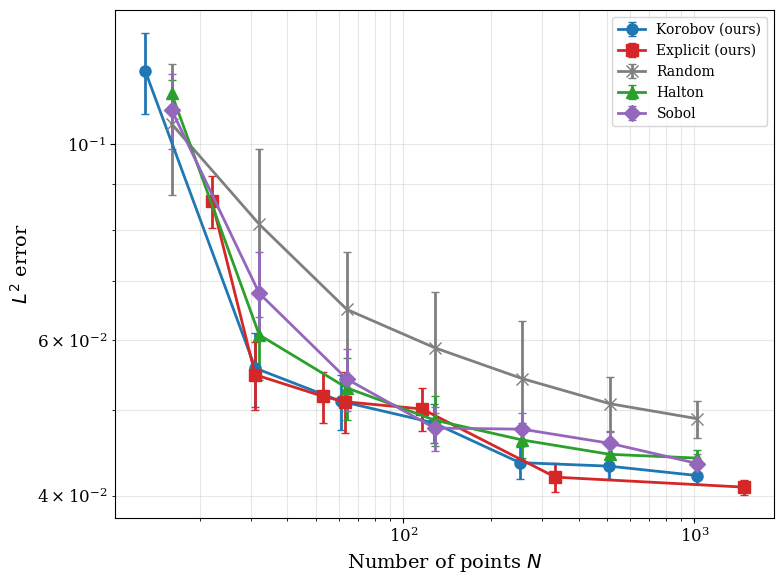

In [23]:
# Plot Genz Continuous results
plot_gpr_results(results_continuous, d=3, func_name="Genz Continuous")

Saved: gpr_error_genz_gaussian_3d.pdf, gpr_error_genz_gaussian_3d.png


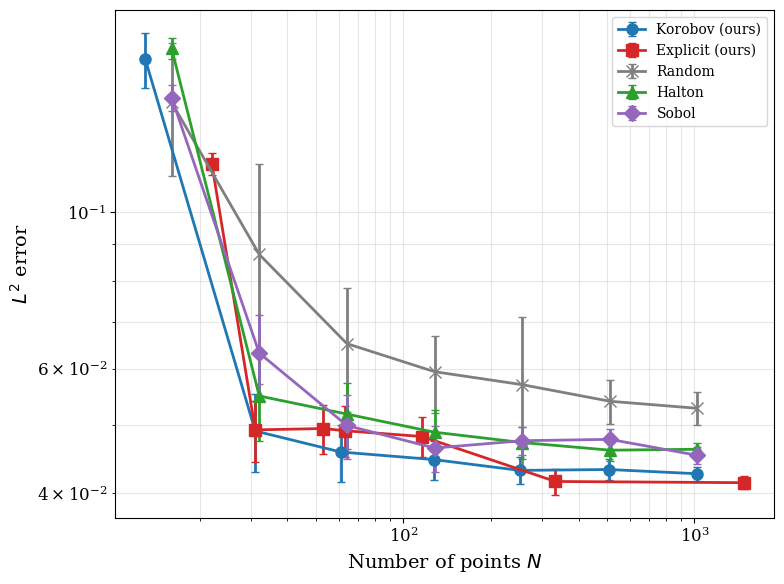

In [25]:
# Plot Genz Gaussian results
plot_gpr_results(results_gaussian, d=3, func_name="Genz Gaussian")